# Downloading scripts and extracting character lines

In [8]:
import pandas as pd
import lyricsgenius
import json
import numpy as np
import networkx as nx
import pickle
import ast
import seaborn as sns

In [33]:
episodefile = open("../data/EpisodeList.txt","r")
episodeList = []

for line in episodefile:
    episodeList.append(line.strip().lower().replace(",",""))

SeasonList = [10,10,10,10,10,10,7,6]
episodeTuple = []
ekstranumb = 0
for numb in range(len(SeasonList)):
    for i in range(SeasonList[numb]):
        episodeTuple.append((numb+1, episodeList[i+ekstranumb]))
    ekstranumb += SeasonList[numb]

Below, all scripts are downloaded using the lyrics genius api. 

Caution: this takes a long time to run and overwrites the script files which are already present. For that reason they are outcommented.

In [104]:
#genius = lyricsgenius.Genius("Apa5yYNZVRkIvn1izsQWN5l957pSR9jiG24s8ExAPKE9FHY9gdq4W8P7GPavWn1n")
#artist = genius.search_artist("Game of Thrones")
#artist.save_lyrics()

Below is a slightly complicated dict comprehension that creates a dictionary with episodes being the key, and the scripts being the value. 

The scripts were downloaded using the Genius api, and therefore the episodes are accessed using the "songs" keyword, as the genius website, and thus its API, usually deals in songs, but apparently also posts some movie scripts as is the case here.

In [34]:

jFile = open("Lyrics_GameofThrones.json", "r")
j = json.load(jFile)

LyricsListDict = {j["songs"][w]["title_with_featured"].lower().replace(",",""):j["songs"][w]["lyrics"].encode("UTF-8").decode("UTF-8") 
                    for w in range(len(j["songs"])) 
                    if j["songs"][w]["title_with_featured"].lower().replace(",","") in episodeList}

Here a dictionary is created using the title of each episode as the key and the values being two other dictionarys keys, one being the script for the episode. Season 1 was formatted differently, so these scripts were manually edited a bit to make the parsing easier, for that reason, season 1 scripts are extracted from txt files instead of from the LyricsListDict

This is the format of the dict: 

SeasonDict format -> {Title:{Season:SeasonNumber,Script:ScriptText}}

In [35]:
SeasonDict = dict()

season1counter = 0
for season, title in episodeTuple:
    if season != 1:
        SeasonDict[title] = {"season": int(season),"script":LyricsListDict[title]}
    else:
        season1counter += 1
        script = ""
        path = f"../data/GOT_Season_1_Formatted/Episode{season1counter}.txt"
        with open(path,'r') as file:
            script = " ".join(file.readlines())
        SeasonDict[title] = {"season": int(season),"script":script}

Below is the functions used for extracting the lines spoken in the scripts.

The sceneNameChecker function tries to find out if a line is the start of a new scene and attempts to extract a name for the scene.

The createDataframefromDict function takes the SeasonDict created above, and parses all keys inorder to find out what is a spoken line, and what is a new scene etc. This is saved to a dataframe, with each row being a new line spoken. Each row has metadata, such a person that spoke, episode title etc.

In [36]:
def sceneNameChecker(screenLine:str, i:int, lineSplit:str, sceneList:list, saveResult: bool):
    sceneName = None
    
    if lineSplit[0].upper() == "CUT TO":
        sceneName = lineSplit[1].strip()

    elif screenLine.strip().startswith('EXT'):
        sceneName = screenLine.strip()[4:].strip()

    elif screenLine.strip().startswith('INT'):
        sceneName = screenLine.strip()[4:].strip()

    elif 'EXT.' in screenLine.strip():
        sceneName = screenLine.split("EXT.")[1].strip()

    elif 'EXT:' in screenLine.strip():
        sceneName = screenLine.split("EXT:")[1].strip()

    elif 'INT:' in screenLine.strip():
        sceneName = screenLine.split("INT:")[1].strip()

    elif 'INT.' in screenLine.strip():
        sceneName = screenLine.split("INT.")[1].strip()
        
    elif screenLine.strip().startswith("--------"):
        sceneName = "Unnamed Scene"

    elif screenLine.upper().strip().startswith("CUT TO"):
        sceneName = screenLine.strip()[7:].strip()

    elif "SCENE SHIFTS" in screenLine.upper():
        sceneName = screenLine.upper().split("SCENE SHIFTS")[1].split(".")[0].replace(",","").strip()

    elif "SCENE CHANGES" in screenLine.upper():
        sceneName = screenLine.upper().split("SCENE CHANGES")[1].split(".")[0].replace(",","").strip()

    elif "NEWSCENE" in screenLine.upper():
        sceneName = "New Scene"

    elif i == 0:
        sceneName = "Opening Scene"
    
    #Giving the sceneName an extra number if the sceneName occurs multiple times 
    if sceneName is not None:
        if str(sceneName) in sceneList:
            try:
                sceneNameOld = sceneName
                sceneName = str(sceneName) + "_" + str(sceneList.count(sceneName))
                if saveResult is False:
                    return True, True, True
                sceneList.append(str(sceneNameOld))
                
            except TypeError as error:
                print("Error:", sceneName)
            
        else:
            if saveResult is False:
                return True, "True", "True"
            sceneList.append(str(sceneName))
        
        return True, str(sceneName), sceneList
       
        
    return False, False, False


def createDataframefromDict(screenplayDict:dict):
 
    dfcolumns = ['Person','SeasonNr','EpisodeID','EpisodeTitle','Scene','ScreenLine']


    sceneList = []
    allLines = []
    episodeID = 0
    

    for title in screenplayDict:

        episodeTitle = title
        episodeID += 1
        seasonNr = int(screenplayDict[title]['season'])
        
        sceneName = None

        screenLines = screenplayDict[title]['script'].replace("\n\n\n", "NEWSCENE\n")
        if seasonNr == 1 and episodeID != 8:
            screenLines = screenLines.split("\n \n")
        else:
            screenLines = screenLines.split("\n")
        if "" in screenLines:
            screenLines.remove("")
        
        for i in range(len(screenLines)):
            
            lines = screenLines[i].split("\n")
            
            for line in lines:
        
                lineSplit = line.strip().split(":")
                

                if len(lineSplit) > 1 or sceneNameChecker(line,i,lineSplit,sceneList, False)[0] is True:

                    if sceneNameChecker(line,i,lineSplit,sceneList, False)[0] is True:
                        _, sceneName, sceneList = sceneNameChecker(line,i,lineSplit, sceneList, True)
                                    

                    elif len(lineSplit) >= 2:
                        if sceneName is None:
                            _, sceneName, sceneList = sceneNameChecker(line,0,lineSplit, sceneList, True)

                        person = str(lineSplit[0].split("(")[0].strip()).upper()
                        screenLine = str(lineSplit[1]).strip()
                        
                        newEntry = [person, seasonNr, episodeID, episodeTitle, sceneName, screenLine]
                        
                        allLines.append(newEntry)
                        
                    
                else:
                    if ("EXT.") in line:
                        print(i,episodeID, "Error", lineSplit)
                    if "SCENE SHIFTS" in str(line).upper() or "SCENE CHANGES" in str(line).upper() and len(line[0].strip()) > 0:
                        
                        _, sceneName, sceneList = sceneNameChecker(line,0,lineSplit, sceneList, True)
                        #print(sceneName)
            


    df = pd.DataFrame(allLines,columns=dfcolumns)
    return df

This function is used to format the names correctly as they are written in slightly different ways and sometimes misspelled in these transcriptions. Other times a character is only mentioned by their first name or are called king ... and this function also handles such cases. The "correct" names were found by accessing the Game of Thrones wiki page and collecting the names from each page on there. 

In [37]:
def format_name(person_list: list, verbose = False) -> list:
    metadata = pd.read_csv('../data/characher_metadata2.csv')
    c2n = pd.read_csv('../data/characterToName.csv', header = None)

    # 'One comprehenssion to rule them all, One comprehenssion to find them, One comprehenssion to bring them all and in the darkness bind them.
    alias2name = {alias.strip().lower():name.strip().lower() for alias, name in zip(c2n.iloc[:,0],c2n.iloc[:,1]) if alias is not np.nan and name is not np.nan}
    metadata_ls = [person.lower() for person in metadata.iloc[:,0]]
    metadata_uniq = set(metadata_ls)

    
    valid_persons = []
    for person in person_list:
        person = person.lower()
        person = person.replace('king', '')
        person = person.replace('young', '')
        person = person.replace('ser', '')
        person = person.replace('lord', '')
        person = person.replace('maester', '')
        person = person.replace('grand maester', '')
        person = person.strip()
    
        if person in metadata_uniq:
            valid_persons.append(person)
    
            
        if person not in metadata_uniq:
            if person in alias2name:
                valid_persons.append(alias2name[person])
                if verbose and person != alias2name[person]:
                    print(f'{person} -> {alias2name[person]}')
                    pass
            else:
                valid_persons.append(np.nan)
                if verbose:
                    print(f'{person} -> nan')
    
    
    
    return valid_persons

The dataframe is created by using the function, afterwhich the "Person" column is renamed using the format_name function. At last, any nans are dropped, which occurs for a multitude of reasons.

In [38]:
df = createDataframefromDict(SeasonDict)
df["Person"] = format_name(df.Person, verbose = False)
pd.DataFrame.dropna(df,axis=0, how = 'any', inplace = True)
df

,Person,SeasonNr,EpisodeID,EpisodeTitle,Scene,ScreenLine
0,waymar royce,1,1,winter is coming,Unknown,What d'you expect? They're savages. One lot st...
1,will,1,1,winter is coming,Unknown,I've never seen wildlings do a thing like this...
2,waymar royce,1,1,winter is coming,Unknown,How close did you get?
3,will,1,1,winter is coming,Unknown,Close as any man would.
4,gared,1,1,winter is coming,Unknown,We should head back to the wall.
...,...,...,...,...,...,...
24997,sam,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,Uh... the Archmaester is less than enthusiasti...
24998,bronn,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,"Well, I imagine he isn't using them properly."
24999,brienne of tarth,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,I think we can all agree that ships take prece...
25000,bronn,8,73,the iron throne,SMALL COUNCIL CHAMBER_4,I think that's a very presumptuous statement.


The dataframe is saved for later processing.

In [39]:
df.to_csv('../data/scene_data.csv')


Another file containing character metadata, such as which house a character belongs to, along with other affiliations, are opened and its informations are added to the scene dataframe.

In [40]:
D = pd.read_csv('../data/characher_metadata2.csv')
#Creating house dict
houseDict = dict()
for name, houses, affiliation in zip(D.iloc[:,0],D.iloc[:,1],D.iloc[:,2]):
    houseDict[name.lower()] = {}
    if houses.strip('[]') != '':   
        houses = ast.literal_eval(houses)
        houselist = []
        for house in houses:
            houselist.append(house.split("/")[0])
            
        houseDict[name.lower()]["house"] = houselist
    if affiliation.strip('[]') != '':  
        affiliation = ast.literal_eval(affiliation)
        affiliations = []
        for aff in affiliation:
            affiliations.append(aff.split("/")[0])
        
        houseDict[name.lower()]["affiliations"] = affiliations

count = 0
for name, house in houseDict.items():
    if len(house) > 2:
        print(name, house)
        count+= 1

def getAffiliationsToDF(persons, houseDict):
    houseList = []
    affiliationList = []
    for person in persons:
        try:
            houseList.append(", ".join(houseDict[person]["house"]).strip())
        except KeyError as error:
            
            houseList.append("None")
        try:
            affiliationList.append(", ".join(houseDict[person]["affiliations"]).strip())
        except KeyError as error:
            
            affiliationList.append("None")
    return houseList, affiliationList
df["House"], df["Affiliations"] = getAffiliationsToDF(df["Person"], houseDict)
df.to_csv('../data/scene_data.csv')

A dict containing informations such as lines spoken, seasonnr of the line, episodeid and title is created, to be used for creating the network and for assigning attributes to the edges.

In [41]:
lineDict = dict()

# LineDict -> key: Scene -> key: person -> value: lines
#                        -> value: seasonnr
#                        -> value: EpisodeID
#                        -> value: EpisodeTitle

for scene, person, lines, seasonNr, episodeID, episodeTitle in zip(df.Scene, df.Person, df.ScreenLine, df.SeasonNr, df.EpisodeID, df.EpisodeTitle):
    if scene not in lineDict:
        lineDict[scene] = {}
  
    if person not in lineDict[scene]:
        lineDict[scene][person] = {}
        lineDict[scene][person]["SeasonNr"] = seasonNr
        lineDict[scene][person]["EpisodeID"] = episodeID
        lineDict[scene][person]["EpisodeTitle"] = episodeTitle
        
    if "lines" not in lineDict[scene][person]: 
        lineDict[scene][person]["lines"] = []
    

    lineDict[scene][person]["lines"].append(lines)

personLineDict = dict()

for scene, person, lines, seasonNr, episodeID, episodeTitle in zip(df.Scene, df.Person, df.ScreenLine, df.SeasonNr, df.EpisodeID, df.EpisodeTitle):
    if person not in personLineDict:
        personLineDict[person] = {}
    
    connectedPersons = [cp for cp in (lineDict[scene]) if cp != person]


    for otherPerson in connectedPersons:

        if otherPerson not in personLineDict[person]:
            personLineDict[person][otherPerson] = {}

        if seasonNr not in personLineDict[person][otherPerson]:
            personLineDict[person][otherPerson][seasonNr] = {}
        
        if episodeID not in personLineDict[person][otherPerson][seasonNr]:
            personLineDict[person][otherPerson][seasonNr][episodeID] = {}

        if episodeTitle not in personLineDict[person][otherPerson][seasonNr][episodeID]:
            personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle] = {}
            
        if scene not in personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle]:
            personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle][scene] = lineDict[scene][person]["lines"]
   
    

print("Nr of scenes in dict:", len(lineDict))
print("Nr of persons in personLineDict:", len(personLineDict))
#lineDict["Unnamed Scene"]

Nr of scenes in dict: 1561
Nr of persons in personLineDict: 344


# Creating the network
A directed graph is created and a list of the nodes to be added to the graph is created, containing any house information if the character belongs to a house. 
Edges are added between persons that are speaking in the same scene, saving all lines the one character says in the scene, as an edge attribute. 

In [42]:
PersonList = set(list(df.Person))

nodeList = []
for person in PersonList:
    if person in houseDict:
        nodeList.append((person, houseDict[person]))
    else:
        nodeList.append((person))

G = nx.DiGraph()
G.add_nodes_from(nodeList)

for person in personLineDict:  
    #print(person)  
    for connectedPersons, lines in personLineDict[person].items():

        G.add_edge(person, connectedPersons, lines = lines)
                

print(len(G.nodes()))
file = open("GOTNetwork.pkl",'wb')
pickle.dump(G,file)
file.close()

344


The closeness and degree centrality of the network is calculated and sorted from largest fraction to smallest. Only the centrality measure made it into the report.

In [43]:
closenesscentrality = nx.closeness_centrality(G)
centrality = sorted(closenesscentrality.items(), key = lambda x: -x[1])
print(centrality)

degreecentrality = nx.degree_centrality(G)
centrality = sorted(degreecentrality.items(), key = lambda x: -x[1])
print(centrality)

[('tyrion lannister', 0.5806700991859978), ('jon snow', 0.5565558924091706), ('arya stark', 0.5510635645235538), ('sansa stark', 0.550158698243548), ('jaime lannister', 0.5465687556775215), ('cersei lannister', 0.5326655758828629), ('daenerys targaryen', 0.5309772539307778), ('bran stark', 0.5292996006798115), ('brienne of tarth', 0.5259758983207548), ('davos seaworth', 0.5235103862973761), ('sandor clegane', 0.5235103862973761), ('bronn', 0.5202587689911813), ('theon greyjoy', 0.517846440850573), ('sam', 0.5154563803543395), ('tormund', 0.5146645886794481), ('eddard stark', 0.5030730438893705), ('gendry', 0.49344130667204816), ('catelyn stark', 0.49344130667204816), ('podrick payne', 0.490551460073676), ('grey worm', 0.48911919303696455), ('petyr baelish', 0.4869864058580243), ('varys', 0.4869864058580243), ('wolkan', 0.48417145553514557), ('yara greyjoy', 0.48208150680621686), ('yohn royce', 0.4786380674718867), ('samwell tarly', 0.4752434712486818), ('robb stark', 0.4725622668974904

Here the centrality measures are plotted as histograms ontop of eachother. 

/home/tbr/miniconda3/envs/SocialG/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tbr/miniconda3/envs/SocialG/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tbr/miniconda3/envs/SocialG/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tbr/miniconda3/envs/SocialG/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

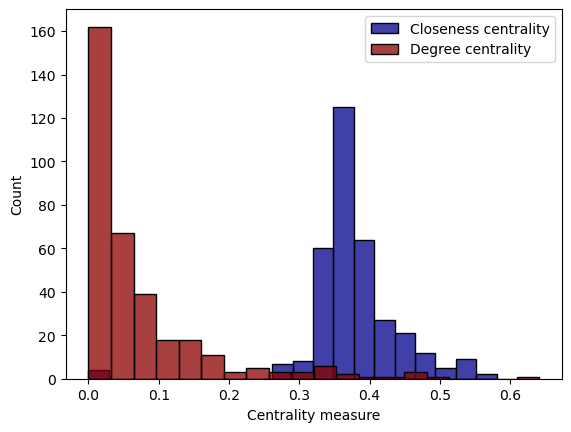

In [44]:
import matplotlib.pyplot as plt
plt.figure()
sns.histplot(x = [float(closenesscentrality[k]) for k in closenesscentrality.keys()], bins = 20, color="darkblue")
sns.histplot(x = [float(degreecentrality[k]) for k in degreecentrality.keys()], bins = 20, color = "darkred")
plt.xlabel("Centrality measure")
plt.legend(["Closeness centrality","Degree centrality"])